In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scikeras.wrappers import KerasClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

2023-01-07 17:12:05.721076: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


ImportError: SciKeras requires TensorFlow >= 2.7.0.

In [ ]:
def find_cabin_type(cabin):

    try:
        c = cabin.split('/')
        return '{}{}'.format(c[0],c[2])
    except:
        return cabin
    

In [ ]:
def get_last_name(name):
    try:
        return name.split(' ')[-1]
    except Exception as e:
        return name

In [ ]:
def count_number_relatives(df):
    df['NumberRelatives'] = df.groupby('LastName')['LastName'].transform('count')
    df.loc[(df['LastName'] == np.nan), 'NumberRelatives'] = 0

In [ ]:
def fill_missing_data(df):
    df.fillna(df.mode().iloc[0], inplace=True)

In [ ]:
def feature_preprocessing(df):
    df['CabinType'] = df['Cabin'].apply(find_cabin_type)
    df['LastName'] = df['Name'].apply(get_last_name)
    count_number_relatives(df)

    #df.fillna(df.mean())
    df.fillna(df.mode().iloc[0], inplace=True)

    df['HomePlanet'].replace(['Europa', 'Earth', 'Mars'],[1, 2, 3], inplace=True)
    df['CryoSleep'].replace([False, True],[0, 1], inplace=True)
    df['VIP'].replace([False, True],[0, 1], inplace=True)
    df['Destination'].replace(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'],[1, 2, 3], inplace=True)
    df['CabinType'].replace(['BP','FS','AS','FP','GS','GP','ES','DP','CS','CP','DS','BS','AP','EP','TP','TS'],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], inplace=True)
    
    df.head()
    df.info()

    return df

In [ ]:
def show_metrics_and_conf_matrix(model, predictions, y_test):

    print(classification_report(y_test, predictions))

    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


In [ ]:
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def create_model(neurons=8, optimizer='SGD', dropout_rate=0.1, activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_shape=(12,), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Etapa 1

treinamento com os dados sem pre-processamento

In [ ]:
orig_df = pd.read_csv('train.csv')
orig_test_df = pd.read_csv('test.csv')

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

### Treinamento com os dados originais

In [ ]:
'''fill_missing_data(df)
fill_missing_data(test_df)

df['HomePlanet'].replace(['Europa', 'Earth', 'Mars'],[1, 2, 3], inplace=True)
df['CryoSleep'].replace([False, True],[0, 1], inplace=True)
df['VIP'].replace([False, True],[0, 1], inplace=True)
df['Destination'].replace(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'],[1, 2, 3], inplace=True)
df['Transported'].replace([False, True],[0, 1], inplace=True)'''


"fill_missing_data(df)\nfill_missing_data(test_df)\n\ndf['HomePlanet'].replace(['Europa', 'Earth', 'Mars'],[1, 2, 3], inplace=True)\ndf['CryoSleep'].replace([False, True],[0, 1], inplace=True)\ndf['VIP'].replace([False, True],[0, 1], inplace=True)\ndf['Destination'].replace(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'],[1, 2, 3], inplace=True)\ndf['Transported'].replace([False, True],[0, 1], inplace=True)"

In [ ]:
'''sn.heatmap(df.corr(), annot=True)
plt.show()'''

'sn.heatmap(df.corr(), annot=True)\nplt.show()'

In [ ]:
'''df.drop(columns=['Name', ''])

df = pd.get_dummies(df)
test_df = pd.get_dummies(test_df)

y = df['Transported']
X = df.drop(columns=['Transported'])

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=9)

df.head()'''

"df.drop(columns=['Name', ''])\n\ndf = pd.get_dummies(df)\ntest_df = pd.get_dummies(test_df)\n\ny = df['Transported']\nX = df.drop(columns=['Transported'])\n\nx_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=9)\n\ndf.head()"

### Préprocessamento dos dados

In [ ]:
print(df['HomePlanet'].unique())
print(df['Cabin'].nunique())
print(df['Destination'].unique())

['Europa' 'Earth' 'Mars' nan]
6560
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


In [ ]:
df = feature_preprocessing(df)
df['Transported'].replace([False, True],[0, 1], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8693 non-null   int64  
 2   CryoSleep        8693 non-null   int64  
 3   Cabin            8693 non-null   object 
 4   Destination      8693 non-null   int64  
 5   Age              8693 non-null   float64
 6   VIP              8693 non-null   int64  
 7   RoomService      8693 non-null   float64
 8   FoodCourt        8693 non-null   float64
 9   ShoppingMall     8693 non-null   float64
 10  Spa              8693 non-null   float64
 11  VRDeck           8693 non-null   float64
 12  Name             8693 non-null   object 
 13  Transported      8693 non-null   bool   
 14  CabinType        8693 non-null   int64  
 15  LastName         8693 non-null   object 
 16  NumberRelatives  8693 non-null   float64
dtypes: bool(1), fl

In [ ]:
test_df = feature_preprocessing(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      4277 non-null   object 
 1   HomePlanet       4277 non-null   int64  
 2   CryoSleep        4277 non-null   int64  
 3   Cabin            4277 non-null   object 
 4   Destination      4277 non-null   int64  
 5   Age              4277 non-null   float64
 6   VIP              4277 non-null   int64  
 7   RoomService      4277 non-null   float64
 8   FoodCourt        4277 non-null   float64
 9   ShoppingMall     4277 non-null   float64
 10  Spa              4277 non-null   float64
 11  VRDeck           4277 non-null   float64
 12  Name             4277 non-null   object 
 13  CabinType        4277 non-null   int64  
 14  LastName         4277 non-null   object 
 15  NumberRelatives  4277 non-null   float64
dtypes: float64(7), int64(5), object(4)
memory usage: 534.8+ KB


In [ ]:
print(df['HomePlanet'].unique())
print(df['CabinType'].unique())
print(df['Destination'].unique())

[1 2 3]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1 2 3]


In [ ]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinType,LastName,NumberRelatives
0,0001_01,1,0,B/0/P,1,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,Ofracculy,1.0
1,0002_01,2,0,F/0/S,1,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,2,Vines,4.0
2,0003_01,1,0,A/0/S,1,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,3,Susent,6.0
3,0003_02,1,0,A/0/S,1,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,3,Susent,6.0
4,0004_01,2,0,F/1/S,1,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,2,Santantines,6.0


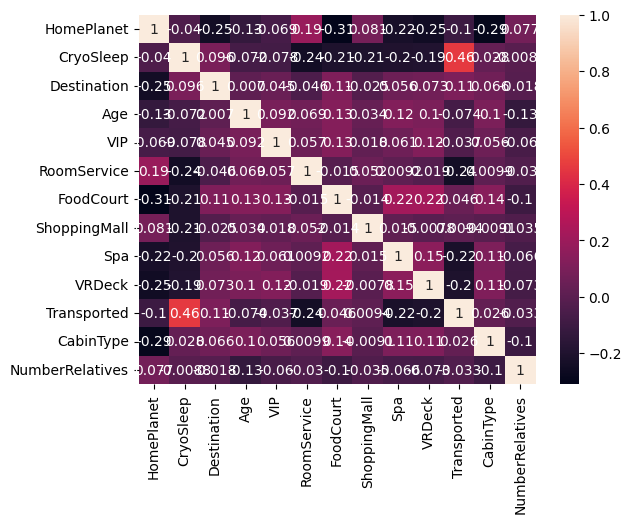

In [ ]:
sn.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
y = df['Transported']
X = df.drop(columns=['Transported', 'PassengerId', 'Cabin', 'Name', 'LastName'])

In [ ]:
num_classes = 2
y = keras.utils.to_categorical(y, num_classes)
print(y)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
test_df_clean = test_df.drop(columns=['PassengerId', 'Cabin', 'Name', 'LastName'])
test_df_clean.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinType,NumberRelatives
0,2,1,1,27.0,0,0.0,0.0,0.0,0.0,0.0,5,4.0
1,2,0,1,19.0,0,0.0,9.0,0.0,2823.0,0.0,2,1.0
2,1,1,3,31.0,0,0.0,0.0,0.0,0.0,0.0,9,1.0
3,1,0,1,38.0,0,0.0,6652.0,0.0,181.0,585.0,9,1.0
4,2,0,1,20.0,0,10.0,0.0,635.0,0.0,0.0,2,3.0


### Treinamento do modelo inicial

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=9)

Epoch 1/200


2022-12-01 18:17:03.869563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 18:17:03.886365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2022-12-01 18:17:03.889598: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-01 18:17:03.890286: I tensorflow/core/platform/cpu_feature_guard.cc:151] 

157/157 - 1s - loss: 2.6143 - accuracy: 0.7140 - val_loss: 0.8336 - val_accuracy: 0.7661 - 548ms/epoch - 3ms/step
Epoch 2/200
157/157 - 0s - loss: 0.7365 - accuracy: 0.7739 - val_loss: 0.6739 - val_accuracy: 0.8013 - 136ms/epoch - 866us/step
Epoch 3/200
157/157 - 0s - loss: 0.6476 - accuracy: 0.7803 - val_loss: 0.6359 - val_accuracy: 0.7853 - 149ms/epoch - 951us/step
Epoch 4/200
157/157 - 0s - loss: 0.6234 - accuracy: 0.7856 - val_loss: 0.5347 - val_accuracy: 0.8045 - 163ms/epoch - 1ms/step
Epoch 5/200
157/157 - 0s - loss: 0.5667 - accuracy: 0.7820 - val_loss: 0.5300 - val_accuracy: 0.8051 - 152ms/epoch - 965us/step
Epoch 6/200
157/157 - 0s - loss: 0.5552 - accuracy: 0.7854 - val_loss: 0.5714 - val_accuracy: 0.8045 - 142ms/epoch - 907us/step
Epoch 7/200
157/157 - 0s - loss: 0.5570 - accuracy: 0.7867 - val_loss: 0.5581 - val_accuracy: 0.8032 - 139ms/epoch - 884us/step
Epoch 8/200
157/157 - 0s - loss: 0.5473 - accuracy: 0.7841 - val_loss: 0.5611 - val_accuracy: 0.7949 - 146ms/epoch - 927

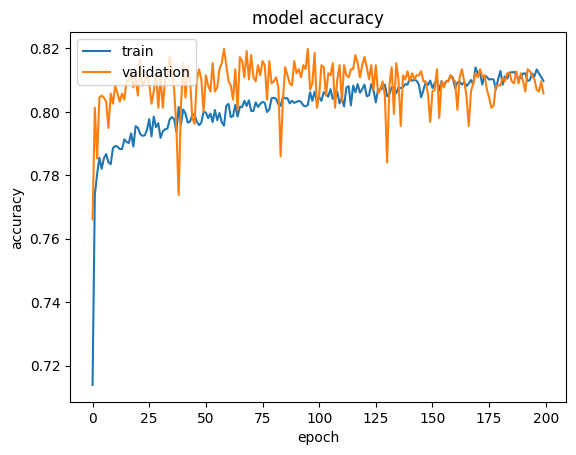

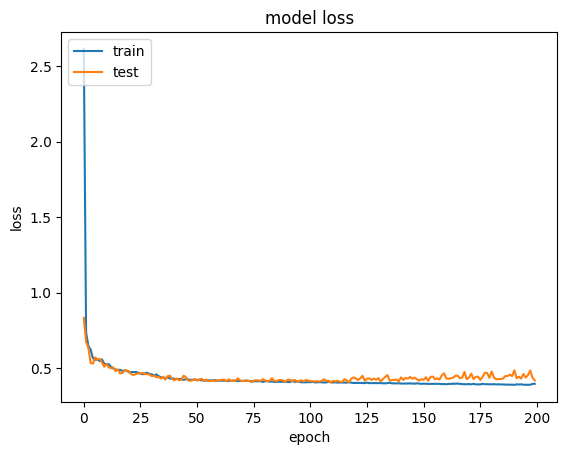

In [ ]:
num_classes = 2

model = Sequential()
model.add(Dense(12, input_shape=(12,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=200, batch_size=40, verbose=2)

test_results = model.evaluate(x_val, y_val, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

print(test_results)

plot_learning_curve(history)
show_metrics_and_conf_matrix(grid_result.best_estimator_, predictions, y_val)

### Treinamento com uso de uso de Scaler

In [ ]:
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.transform(x_val)

Epoch 1/200
157/157 - 1s - loss: 0.5786 - accuracy: 0.7151 - val_loss: 0.4602 - val_accuracy: 0.7879 - 522ms/epoch - 3ms/step
Epoch 2/200
157/157 - 0s - loss: 0.4729 - accuracy: 0.7764 - val_loss: 0.4415 - val_accuracy: 0.8013 - 150ms/epoch - 953us/step
Epoch 3/200
157/157 - 0s - loss: 0.4559 - accuracy: 0.7817 - val_loss: 0.4365 - val_accuracy: 0.8019 - 142ms/epoch - 905us/step
Epoch 4/200
157/157 - 0s - loss: 0.4445 - accuracy: 0.7876 - val_loss: 0.4320 - val_accuracy: 0.7923 - 150ms/epoch - 954us/step
Epoch 5/200
157/157 - 0s - loss: 0.4359 - accuracy: 0.7902 - val_loss: 0.4239 - val_accuracy: 0.8064 - 149ms/epoch - 952us/step
Epoch 6/200
157/157 - 0s - loss: 0.4318 - accuracy: 0.7897 - val_loss: 0.4221 - val_accuracy: 0.8006 - 144ms/epoch - 918us/step
Epoch 7/200
157/157 - 0s - loss: 0.4272 - accuracy: 0.7913 - val_loss: 0.4200 - val_accuracy: 0.7930 - 155ms/epoch - 986us/step
Epoch 8/200
157/157 - 0s - loss: 0.4243 - accuracy: 0.7945 - val_loss: 0.4198 - val_accuracy: 0.7981 - 147

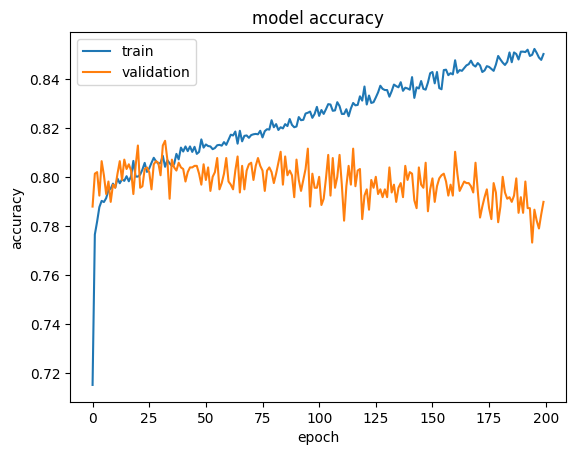

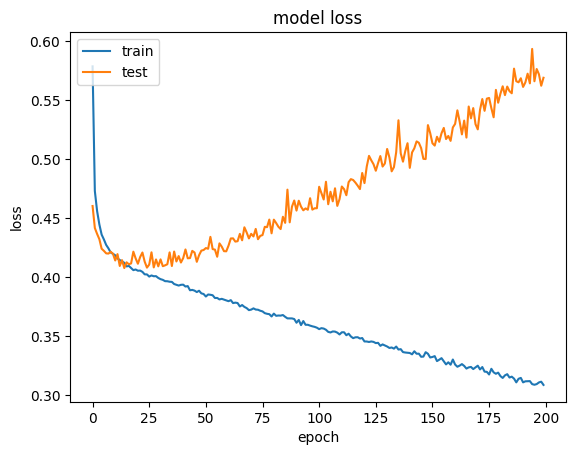

In [ ]:
num_classes = 2

model = Sequential()
model.add(Dense(12, input_shape=(12,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=200, batch_size=40, verbose=2)

test_results = model.evaluate(x_val, y_val, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

print(test_results)

plot_learning_curve(history)
show_metrics_and_conf_matrix(grid_result.best_estimator_, predictions, y_val)

### Treinamento com adição de uma camada de dropout

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=9)

Epoch 1/200
157/157 - 1s - loss: 5.2462 - accuracy: 0.5879 - val_loss: 1.1721 - val_accuracy: 0.7898 - 528ms/epoch - 3ms/step
Epoch 2/200
157/157 - 0s - loss: 1.8529 - accuracy: 0.7226 - val_loss: 0.8290 - val_accuracy: 0.7904 - 167ms/epoch - 1ms/step
Epoch 3/200
157/157 - 0s - loss: 1.2699 - accuracy: 0.7386 - val_loss: 0.6671 - val_accuracy: 0.7859 - 155ms/epoch - 988us/step
Epoch 4/200
157/157 - 0s - loss: 0.9514 - accuracy: 0.7474 - val_loss: 0.5773 - val_accuracy: 0.7764 - 157ms/epoch - 997us/step
Epoch 5/200
157/157 - 0s - loss: 0.7931 - accuracy: 0.7400 - val_loss: 0.5492 - val_accuracy: 0.7655 - 150ms/epoch - 956us/step
Epoch 6/200
157/157 - 0s - loss: 0.6985 - accuracy: 0.7411 - val_loss: 0.5247 - val_accuracy: 0.7859 - 151ms/epoch - 961us/step
Epoch 7/200
157/157 - 0s - loss: 0.6433 - accuracy: 0.7422 - val_loss: 0.5229 - val_accuracy: 0.7891 - 170ms/epoch - 1ms/step
Epoch 8/200
157/157 - 0s - loss: 0.6062 - accuracy: 0.7499 - val_loss: 0.5215 - val_accuracy: 0.7847 - 157ms/e

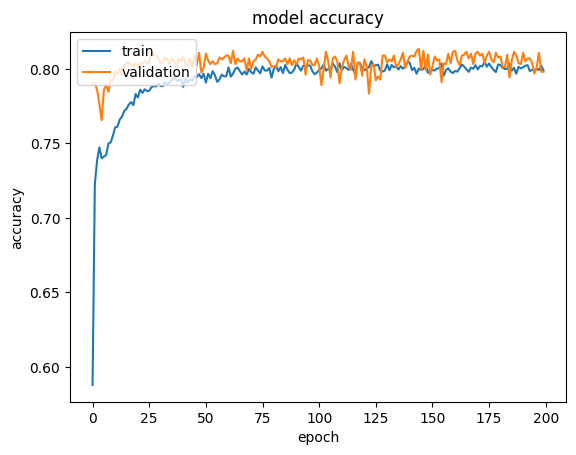

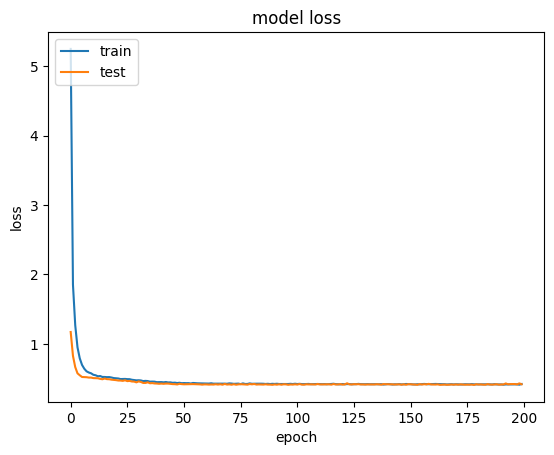

In [ ]:
num_classes = 2

model = Sequential()
model.add(Dense(12, input_shape=(12,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=200, batch_size=40, verbose=2)

test_results = model.evaluate(x_val, y_val, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

print(test_results)

plot_learning_curve(history)
show_metrics_and_conf_matrix(grid_result.best_estimator_, predictions, y_val)

### Grid Search

In [ ]:
model = KerasClassifier(model=create_model, loss="binary_crossentropy", verbose=0)
# define the grid search parameters

batch_size = [10, 20, 40, 60]
epochs = [50, 100, 150]
neurons = [8, 16, 32, 64]
learn_rate = [0.001, 0.01, 0.1, 0.2]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

params = dict(batch_size=batch_size, epochs=epochs, model__optimizer=optimizer, optimizer__learning_rate=learn_rate, optimizer__momentum=momentum, model__activation=activation, model__neurons=neurons, model__dropout_rate=dropout_rate)
#params = dict(model__epochs=epochs, model__neurons=neurons)
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_jobs=-1, cv=5, scoring='accuracy')
#grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=3, scoring='accuracy')
grid_result = grid.fit(x_train, y_train, validation_split=0.2, shuffle=True)

print(grid_result.best_params_)
print(grid_result.best_score_)

predictions = grid_result.best_estimator_.predict(x_val)

print(predictions)



2022-12-01 18:29:08.391771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 18:29:08.394466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 18:29:08.394547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 18:29:08.398315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2022-12-01 18:29:08.398826: I tenso

{'optimizer__momentum': 0.2, 'optimizer__learning_rate': 0.01, 'model__optimizer': 'Adam', 'model__neurons': 16, 'model__dropout_rate': 0.4, 'model__activation': 'linear', 'epochs': 100, 'batch_size': 40}
0.7825669414869711
[[0 1]
 [1 0]
 [0 1]
 ...
 [1 0]
 [0 1]
 [1 0]]


Epoch 1/100
157/157 - 1s - loss: 22.9514 - accuracy: 0.6767 - val_loss: 1.6557 - val_accuracy: 0.7450 - 544ms/epoch - 3ms/step
Epoch 2/100
157/157 - 0s - loss: 2.1970 - accuracy: 0.6409 - val_loss: 0.9007 - val_accuracy: 0.6754 - 153ms/epoch - 971us/step
Epoch 3/100
157/157 - 0s - loss: 1.1509 - accuracy: 0.6259 - val_loss: 0.6949 - val_accuracy: 0.6696 - 149ms/epoch - 950us/step
Epoch 4/100
157/157 - 0s - loss: 0.8324 - accuracy: 0.6082 - val_loss: 0.6626 - val_accuracy: 0.6581 - 148ms/epoch - 943us/step
Epoch 5/100
157/157 - 0s - loss: 0.7378 - accuracy: 0.6822 - val_loss: 0.5779 - val_accuracy: 0.7796 - 146ms/epoch - 930us/step
Epoch 6/100
157/157 - 0s - loss: 0.6901 - accuracy: 0.7210 - val_loss: 0.5684 - val_accuracy: 0.7815 - 138ms/epoch - 876us/step
Epoch 7/100
157/157 - 0s - loss: 0.6284 - accuracy: 0.7399 - val_loss: 0.5506 - val_accuracy: 0.7783 - 144ms/epoch - 915us/step
Epoch 8/100
157/157 - 0s - loss: 0.5975 - accuracy: 0.7470 - val_loss: 0.5371 - val_accuracy: 0.7853 - 14

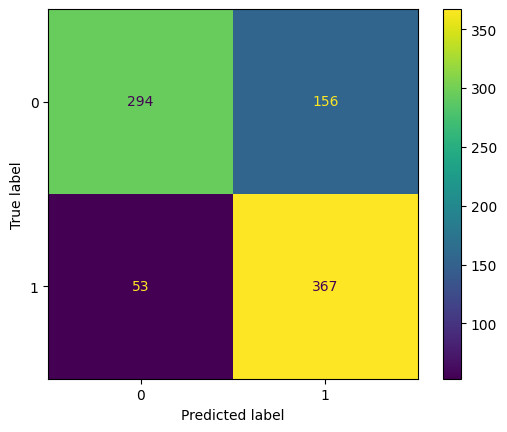

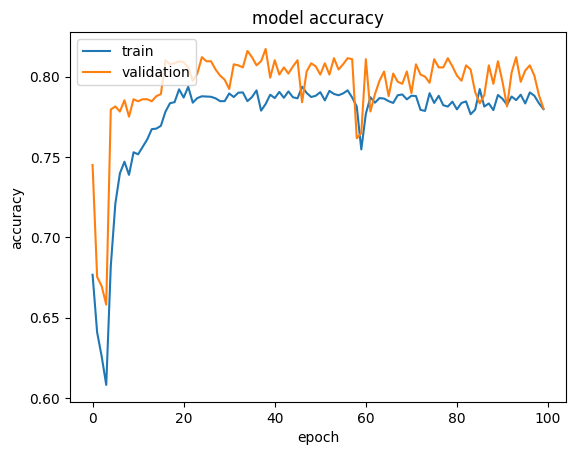

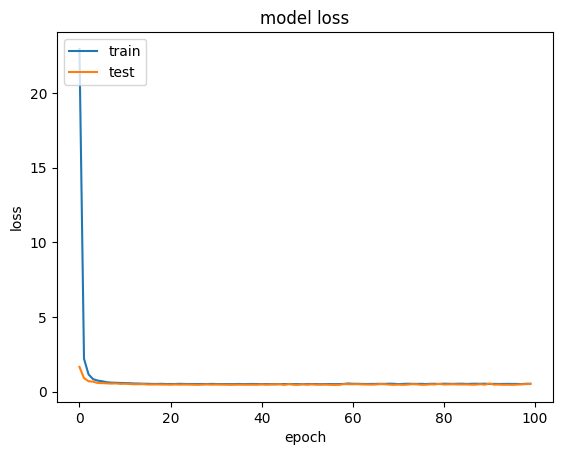

"test_results = grid_result.evaluate(x_val, y_val, verbose=1)\nprint(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')\n\nprint(test_results)"

In [ ]:
# {'optimizer__momentum': 0.2, 'optimizer__learning_rate': 0.01, 'model__optimizer': 'Adam', 'model__neurons': 16, 'model__dropout_rate': 0.4, 'model__activation': 'linear', 'epochs': 100, 'batch_size': 40}
num_classes = 2

model = Sequential()
model.add(Dense(16, input_shape=(12,), activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))


adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=100, batch_size=40, verbose=2)

show_metrics_and_conf_matrix(grid_result.best_estimator_, predictions, y_val)

plot_learning_curve(history)


'''test_results = grid_result.evaluate(x_val, y_val, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

print(test_results)'''

In [ ]:
'''num_classes = 2

model = Sequential()
model.add(Dense(12, input_shape=(12,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=200, batch_size=40, verbose=2)

test_results = model.evaluate(x_val, y_val, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

print(test_results)

plot_learning_curve(history)'''

"num_classes = 2\n\nmodel = Sequential()\nmodel.add(Dense(12, input_shape=(12,), activation='relu'))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(num_classes, activation='softmax'))\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nhistory = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=200, batch_size=40, verbose=2)\n\ntest_results = model.evaluate(x_val, y_val, verbose=1)\nprint(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')\n\nprint(test_results)\n\nplot_learning_curve(history)"

In [ ]:
# predictions = grid_result.predict(test_df_clean)
predictions = model.predict(test_df_clean)
print(np.argmax(predictions, axis=1))

[1 0 1 ... 1 0 1]


In [ ]:
submission = pd.DataFrame(np.argmax(predictions, axis=1), columns=['Transported'])
submission['PassengerId'] = test_df.PassengerId
cols=['PassengerId','Transported']

submission['Transported'].replace([0, 1], [False, True], inplace=True)

submission=submission[cols]
display(submission)

'''print(submission.Predicted.max())
print(submission.Predicted.min())'''

submission.to_csv('submission.csv', index=False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False
